**Load libraries**

In [2]:
import LinearAlgebra as linalg
import Statistics as stats
import Distributions as dist
import Random as random
import Plots as plt
import QuantEcon as qe
;

**Utility functions**

**Problem 1**

We have that $w_t = \bar{w} + \rho w_{t-1} + \epsilon_{t}$. Thus $E(w_t) = E(\bar{w} + \rho w_{t-1} + \epsilon_{t}) = \bar{w} + \rho E(w_{t-1})$. We can recursively define $E(w_{t}) = \sum_{j=0}^{t} \rho^{j}\bar{w}$ and as $t \rightarrow \infty$, $E(w_{t}) = \frac{\bar{w}}{1 - \rho}$. We can then define

\begin{align*}
Var(w_t) &= E((w_t - E(w_t))(w_t - E(w_t))') \\
&= E(w_t w_t' - w_t E(w_t)' - E(w_t) w_t' + E(w_t)E(w_t)') \\
&= E(w_t w_t') - E(w_t)E(w_t)' \\
&= E((\bar{w} + \rho w_{t-1} + \epsilon_t)(\bar{w} + \rho w_{t-1} + \epsilon_t)') - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= E(\bar{w}\bar{w}' + \rho^2 w_{t-1}w_{t-1}' + \epsilon_t \epsilon_t' + \rho\bar{w} w_{t-1}' + \bar{w}\epsilon_t' + \rho w_{t-1}\bar{w} + \rho w_{t-1}\epsilon_t' + \epsilon_t\bar{w} + \rho \epsilon_t w_{t-1}') - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \bar{w}^2 + \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \rho\bar{w} E(w_{t-1}') + \rho E(w_{t-1})\bar{w} - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \bar{w}^2 + \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + 2 \rho\bar{w}\frac{\bar{w}}{1 - \rho} - \frac{\bar{w}^2}{(1 - \rho)^2} \\
&= \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho} - \frac{\bar{w}^2}{(1 - \rho)^2}
\end{align*}

and we can use the form $E(w_t w_t') = \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho}$ to recursively solve for the RHS equation.

\begin{align*}
E(w_t w_t') &= \rho^2 E(w_{t-1} w_{t-1}') + \sigma_{e}^{2} + \frac{(1 + \rho)\bar{w}^{2}}{1 - \rho} \\
&= \sum_{i=0}^{t} \rho^{2i} \sigma_{e}^{2} + \frac{(1 + \rho) \rho^{2i}\bar{w}^{2}}{1 - \rho} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 + \rho)\bar{w}^{2}}{(1 - \rho)(1 - \rho^{2})}
\end{align*}

and revisiting $Var(w_t)$,
\begin{align*}
Var(w_t) &= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 - \rho)(1 + \rho)\bar{w}^{2}}{(1 - \rho)^{2}(1 - \rho^{2})} - \frac{(1 - \rho^{2})\bar{w}^2}{(1 - \rho)^2(1 - \rho^{2})} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}} + \frac{(1 - \rho^{2})\bar{w}^{2}}{(1 - \rho)^{2}(1 - \rho^{2})} - \frac{(1 - \rho^{2})\bar{w}^2}{(1 - \rho)^2(1 - \rho^{2})} \\
&= \frac{\sigma_{e}^{2}}{1 - \rho^{2}}
\end{align*}

Given the income process is defined as
\begin{align*}
y_{t} &= exp\{w_t\} \\
&= exp\{\bar{w} + \rho w_{t-1} + e_{t}\}
\end{align*}

and we seek $\bar{w}$ such that $E(y_{t}) = E(exp\{\bar{w} + \rho w_{t-1} + e_{t}\}) = 1$, from the fact that $E(exp\{w_t\}) = exp\{E(w_t) + \frac{1}{2}Var(w_t)\}$,

\begin{align*}
E(y_{t}) = 1 &= E(exp(w_t)) \\
&= exp\{E(w_t) + \frac{1}{2}Var(w_t)\} \\
&= exp\{\frac{\bar{w}}{1 - \rho} + \frac{1}{2}\frac{\sigma_{e}^{2}}{1 - \rho^{2}}\} \\
0 &= \frac{\bar{w}}{1 - \rho} + \frac{1}{2}\frac{\sigma_{e}^{2}}{1 - \rho^{2}} \\
\bar{w} &= -\frac{\sigma_{e}^{2}}{2(1 + \rho)}
\end{align*}

**Theoretical moments**

In [3]:
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
Dₑ = dist.Normal(μₑ, σₑ)
ρ = 0.90

# Set w̄ according to derivations
w̄ = -vₑ / (2*(1 + ρ))
tmean = w̄ / (1 - ρ)
tvar = vₑ / (1 - ρ^2)

# For when we set ρ = 0.98
vₑ98 = (1 - 0.98^2) * tvar
σₑ98 = sqrt(vₑ98)
Dₑ98 = dist.Normal(μₑ, σₑ98)
ρ98 = 0.98
w̄98 = -vₑ98 / (2*(1 + ρ98))
tmean98 = w̄98 / (1 - ρ98)
tvar98 = vₑ98 / (1 - ρ98^2)
;

**Discretization and simulation functions**

In [4]:
#==========================================================================================
# Markov Chain
==========================================================================================#
mutable struct MarkovChain
    theta::Array{Float64}
    states::Array{Float64}
    mean::Union{Float64, Missing}
    var::Union{Float64, Missing}
    std::Union{Float64, Missing}
end

function simulate!(markovchain, periods=1000, burn=0, replications=0; random_state=-1)
    if random_state >= 0
        random.seed!(random_state)
    end
    N = length(markovchain.states)
    
    # Configure CDF
    Θ = Array{dist.Categorical{Float64, Vector{Float64}}}(undef, N)
    for i = 1:N
        Θ[i] = dist.Categorical(markovchain.theta[i, :])
    end

    # Initialize index of realized states and run burn-in
    index_series = Array{Int64}(undef, periods)
    index_series[1] = rand(1:N)
    if burn > 0
        for _ = 1:burn
            index_series[1] = dist.rand(Θ[index_series[1]], 1)[1]
        end
    end

    # Run simulation
    for t = 2:periods
        index_series[t] = dist.rand(Θ[index_series[t-1]], 1)[1]
    end
    
    state_series = Array{Float64}(undef, periods)
    for t = 1:periods
        state_series[t] = markovchain.states[index_series[t]]
    end

    markovchain.mean = stats.mean(state_series)
    markovchain.var = stats.var(state_series)
    markovchain.std = stats.std(state_series)

    # If replication is specified, rerun simulation and take average of moments
    if replications > 0
        for replication = 1:replications
            index_series[1] = rand(1:N)
            if burn > 0
                for _ = 1:burn
                    index_series[1] = dist.rand(Θ[index_series[1]], 1)[1]
                end
            end

            for t = 2:periods
                index_series[t] = dist.rand(Θ[index_series[t-1]], 1)[1]
            end
            
            for t = 1:periods
                state_series[t] = markovchain.states[index_series[t]]
            end

            markovchain.mean += stats.mean(state_series)
            markovchain.var += stats.var(state_series)
            markovchain.std += stats.std(state_series)
        end
        markovchain.mean /= (replications + 1)
        markovchain.var /= (replications + 1)
        markovchain.std /= (replications + 1)
    end

    return state_series
end
;

In [5]:
function tauchen(
    mean,
    variance,
    N,
    m,
    rho;
    print_output=false
    )
    
    std = sqrt(variance)
    states = Array{Float64}(undef, N)
    states[N] = m*sqrt(variance / (1 - rho^2))
    states[1] = -states[N]
    if print_output
        println("States:")
        println(states[1])
    end
    d = (states[N] - states[1])/(N - 1)
    for i = 2:N-1
        states[i] = states[1] + (i - 1)*d
        if print_output
            println(states[i])
        end
    end
    if print_output
        println(states[N])
    end
    
    # Standard normal distribution for the normalized states
    D = dist.Normal(0, 1)
    
    # Transition matrix
    Θ = Array{Float64}(undef, (N, N))
    for i = 1:N
        for j = 1:N
            if j == 1
                Θ[i, j] = dist.cdf(D, (states[j] + d/2 - rho*states[i])/std)
            elseif j == N
                Θ[i, j] = 1 - dist.cdf(D, (states[j] - d/2 - rho*states[i])/std)
            else
                Θ[i, j] = dist.cdf(D, (states[j] + d/2 - rho*states[i])/std) -
                    dist.cdf(D, (states[j] - d/2 - rho*states[i])/std)
            end
        end
    end
    
    if print_output
        println("Θ:")
        for i = 1:N
            println(round.(Θ[i, :], digits=3))
        end
    end
    
    states .+= mean / (1 - rho)

    return MarkovChain(Θ, states, missing, missing, missing)
end

function rouwenhorst(
    mean,
    variance,
    N,
    rho;
    print_output=false
    )

    ψ = sqrt(variance / (1 - rho^2)) * sqrt(N - 1)

    states = Array{Float64}(undef, N)
    states[N] = ψ
    states[1] = -ψ
    if print_output
        println("States:")
        println(states[1])
    end
    d = (states[N] - states[1])/(N - 1)
    for i = 2:N-1
        states[i] = states[1] + (i - 1)*d
        if print_output
            println(states[i])
        end
    end
    if print_output
        println(states[N])
    end

    p = (1 + rho) / 2
    q = p
    
    # Transition matrix
    Θₙ = Array{Float64}(undef, (2, 2))
    Θₙ[1, 1] = p
    Θₙ[1, 2] = 1 - p
    Θₙ[2, 1] = 1 - q
    Θₙ[2, 2] = q
    Θ = Θₙ
    if N > 2
        global Θ
        global Θₙ
        for n = 3:N
            global Θ
            global Θₙ
            Θ = zeros((n, n))
            Θ[1:n-1, 1:n-1] += p .* Θₙ
            Θ[1:n-1, 2:n] += (1 - p) .* Θₙ
            Θ[2:n, 1:n-1] += (1 - q) .* Θₙ
            Θ[2:n, 2:n] += q .* Θₙ
            Θ[2:n-1, :] ./= 2
            Θₙ = Θ
        end
    end
    
    if print_output
        println("Θ:")
        for i = 1:N
            println(round.(Θ[i, :], digits=3))
        end
    end

    states .+= mean / (1 - rho)
    
    return MarkovChain(Θ, states, missing, missing, missing)
end
;

**Value function algorithms**

In [6]:
function u(c, gamma)
    return c^(1 - gamma) / (1 - gamma)
end

function u_c(c, gamma)
    return c^(-gamma)
end

function u_c_inv(c, gamma)
    return c^(-1/gamma)
end

function Eu_c_y(states, y, a1, A2_y, R, gamma, P)
    N = length(states)

    i_y = findfirst(state -> state == y, states)
    P_y = P[i_y, :]
    global u_c_y = 0.0
    for j = 1:N
        u_c_y += P_y[j] * u_c(R*a1 - A2_y[j] + states[j], gamma)
    end
    return u_c_y
end

function cEuler(states, y, a, a1, A2_y, R, beta, gamma, P)
    return u_c(R*a + y - a1, gamma) - beta * R * Eu_c_y(states, y, a1, A2_y, R, gamma, P)
end

function grid_distance(min, max, minval, maxval, i, shape=1)
    minval + (maxval - minval)*((i - min) / (max - min))^shape
end

function pfi_discretization(
    states,
    P,
    grid_length,
    grid_max,
    phi,
    nu,
    R,
    beta,
    gamma;
    max_iterations=1000,
    print_output=false
    )

    N = length(states)

    A = Array{Union{Float64, Missing}}(undef, grid_length)
    A[1] = phi
    A[grid_length] = grid_max
    for i = 2:grid_length-1
        A[i] = A[1] +
            (A[grid_length] - A[1])*((i - 1) / (grid_length - 1))^nu
    end

    Ay1 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    for i = 1:grid_length
        for j = 1:N
            Ay1[i, j] = A[i]
        end
    end

    Ay2 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    for i = 1:grid_length
        for j = 1:N
            Ay2[i, j] = A[i]
        end
    end

    for iteration = 1:max_iterations
        for i = 1:grid_length
            for j = 1:N
                ijk = cEuler(
                    states,
                    states[j],
                    A[i],
                    A[1],
                    Ay2[1, :],
                    R,
                    beta,
                    gamma,
                    P
                )
                if print_output
                    println(i, ", ", j, ": ", ijk)
                end
                if ijk >= 0
                    Ay1[i, j] = A[1]
                else
                    for k = 2:grid_length
                        if print_output
                            println("After (", k, "): ", ijk)
                        end
                        ijk1 = cEuler(
                            states,
                            states[j],
                            A[i],
                            A[k],
                            Ay2[k, :],
                            R,
                            beta,
                            gamma,
                            P
                        )
                        if ijk1 >= 0
                            if abs(ijk1) <= abs(ijk)
                                Ay1[i, j] = A[k]
                            else
                                Ay1[i, j] = A[k-1]
                            end
                            break
                        else
                            ijk = ijk1
                            if print_output
                                println("Before (", k, "): ", ijk)
                            end
                        end
                    end
                end
            end
        end
        if maximum(skipmissing(Ay1 .== Ay2))
            break
        else
            Ay2[:, :] = Ay1[:, :]
        end
        if iteration == max_iterations
            if print_output
                println("Discretization failed to converge.")
            end
        end
    end

    return A, Ay1
end

function bisection(
    states,
    P,
    grid,
    grid_length,
    spoint,
    mpoint,
    epoint,
    a,
    y,
    A2,
    R,
    beta,
    gamma,
    nu;
    tolerance=1e-4,
    print_output=false
    )

    if print_output
        println("a: ", round(a, digits=3))
    end
    A2m = Array{Union{Float64, Missing}}(undef, length(states))
    if grid[1] != spoint
        for i = 1:grid_length - 1
            if grid[i+1] == spoint
                A2m[:] = A2[i+1, :]
                break
            elseif grid[i+1] > spoint
                A2m[:] = A2[i, :] .+ (spoint - grid[i]) .* ((A2[i+1, :] .- A2[i, :]) ./ (grid[i+1] - grid[i]))
                break
            end
        end
    else
        A2m[:] = A2[1, :]
    end
    
    spointE = cEuler(states, y, a, spoint, A2m, R, beta, gamma, P)
    if print_output
        println("S (", round(spoint, digits=2), ") Ay2: ", round.(A2m, digits=2), ", Euler: ", round(spointE, digits=3))
    end
    if spointE > 0.0
        if print_output
            println("Converged to interior solution at startpoint.")
        end
        return spoint
    else
        for i = 1:grid_length - 1
            if grid[i+1] == mpoint
                A2m[:] = A2[i+1, :]
                break
            elseif grid[i+1] > mpoint
                A2m[:] = A2[i, :] .+ (mpoint - grid[i]) .* ((A2[i+1, :] .- A2[i, :]) ./ (grid[i+1] - grid[i]))
                break
            end
        end

        mpointE = cEuler(states, y, a, mpoint, A2m, R, beta, gamma, P)
        if print_output
            println("M (", round(mpoint, digits=2), ") Ay2: ", round.(A2m, digits=2), ", Euler: ", round(mpointE, digits=3))
        end
        if 0.0 <= mpointE && mpointE <= 0.0 + tolerance
            if print_output
                println("Converged to interior solution at midpoint.")
            end
            return mpoint
        elseif mpointE > 0.0 + tolerance
            if print_output
                println("Setting bounds to (spoint, mpoint).")
            end
            return bisection(states, P, grid, grid_length, spoint, (spoint + mpoint)/2, mpoint, a, y, A2, R, beta, gamma, nu; tolerance=tolerance, print_output=print_output)
        else
            if grid[grid_length] == epoint
                A2m[:] = A2[grid_length, :]
            else
                for i = grid_length:-1:2
                    if grid[i-1] == epoint
                        A2m[:] = A2[i-1, :]
                        break
                    elseif grid[i-1] < epoint
                        A2m[:] = A2[i-1, :] .+ (epoint - grid[i-1]) .* ((A2[i, :] .- A2[i-1, :]) ./ (grid[i] - grid[i-1]))
                        break
                    end
                end
            end

            epointE = cEuler(states, y, a, epoint, A2m, R, beta, gamma, P)
            if print_output
                println("E (", round(epoint, digits=2), ") Ay2: ", round.(A2m, digits=2), ", Euler: ", round(epointE, digits=3))
            end
            if epointE < 0.0
                if print_output
                    println("Expand grid length or adjust curvature.")
                end
                return missing
            elseif 0.0 <= epointE && epointE <= 0.0 + tolerance
                if print_output
                    println("Converged to interior solution at endpoint.")
                end
                return epoint
            else
                if print_output
                    println("Setting bounds to (mpoint, epoint).")
                end
                return bisection(states, P, grid, grid_length, mpoint, (mpoint + epoint)/2, epoint, a, y, A2, R, beta, gamma, nu; tolerance=tolerance, print_output=print_output)
            end
        end
    end
end

function pfi_interpolation(
    states,
    P,
    grid_length,
    grid_max,
    phi,
    nu,
    R,
    beta,
    gamma;
    max_iterations=1000,
    tolerance=1e-4,
    print_output=false
    )

    N = length(states)

    A = Array{Union{Float64, Missing}}(undef, grid_length)
    A[1] = phi
    A[grid_length] = grid_max
    for i = 2:grid_length-1
        A[i] = grid_distance(1, grid_length, phi, grid_max, i, nu)
    end

    Ay1 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    Ay2 = Array{Union{Float64, Missing}}(undef, (grid_length, N))
    for j = 1:N
        Ay1[:, j] = A
        Ay2[:, j] = A
    end

    for iteration = 1:max_iterations
        if print_output
            println("Iteration: ", iteration)
        end
        for i = 1:grid_length
            if iteration == 1
                mpoint = A[i]
            else
                mpoint = grid_distance(1, grid_length, phi, grid_max, grid_length/2, nu)
            end
            for j = 1:N
                value = bisection(states, P, A, grid_length, phi, mpoint, grid_max, A[i], states[j], Ay2, R, beta, gamma, nu; tolerance=tolerance, print_output=print_output)
                if typeof(value) != Missing
                    Ay1[i, j] = value
                end
            end
        end
        error = maximum(abs.(skipmissing(Ay1 .- Ay2)))
        if error <= tolerance
            if print_output
                println("\nError (", round(error, digits=4), ") within tolerance in ", iteration, " iterations, exiting.\n")
            end
            break
        else
            for i = 1:grid_length
                for j = 1:N
                    if abs(Ay1[i, j] - Ay2[i, j]) > tolerance
                        Ay2[i, j] = Ay1[i, j]
                    end
                end
            end
            if print_output
                println("\nError (", round(error, digits=4), ") outside of tolerance, updating Ay2.\n")
            end
        end
        if iteration == max_iterations
            println("Interpolation failed to converge.")
        end
    end

    return A, Ay1
end
;

**Problem 1A**

In [7]:
println("Problem 1a)")
markov = tauchen(w̄, vₑ, 5, 3, ρ; print_output=false)
yts5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1a)
Sample moments (T5):
Mean: -0.158
Variance: 0.508

Theoretical moments:
Mean: -0.158
Variance: 0.316


We see that while the Tauchen method maps well to the theoretical mean, the discretized variance is far higher than our theoretical computation.

**Problem 1B**

In [8]:
println("Problem 1b)")
markov = tauchen(w̄, vₑ, 11, 3, ρ; print_output=false)
yts11 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T11):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1b)
Sample moments (T11):
Mean: -0.156
Variance: 0.358

Theoretical moments:
Mean: -0.158
Variance: 0.316


The Tauchen method is now relatively closer to matching both the theoretical mean and variance, though there is still a sizeable discrepancy in the sample variance.

**Problem 1C**

In [9]:
println("Problem 1c)")
markov = rouwenhorst(w̄, vₑ, 5, ρ; print_output=false)
yrs5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (R5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
markov = tauchen(w̄, vₑ, 5, 3, ρ; print_output=false)
yts5 = simulate!(markov, 10000, 1000, 100; random_state=42)
println("\nSample moments (T5):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments:")
println("Mean: ", round(tmean, digits=3))
println("Variance: ", round(tvar, digits=3))

Problem 1c)
Sample moments (R5):
Mean: -0.161
Variance: 0.315

Sample moments (T5):
Mean: -0.158
Variance: 0.508

Theoretical moments:
Mean: -0.158
Variance: 0.316


The Rouwenhorst method is a nearly direct match to the theoretical moments, despite using a grid of just 5 states.

**Problem 1D**

In [10]:
println("Problem 1d)")
markov = tauchen(w̄98, vₑ98, 5, 3, ρ98; print_output=false)
yts5p = simulate!(markov, 10000, 1000, 100; random_state=42)
println("Sample moments (T5, ρ=0.98):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
markov = rouwenhorst(w̄98, vₑ98, 5, ρ98; print_output=false)
yrs5p = simulate!(markov, 10000, 1000, 100; random_state=42)
println("\nSample moments (R5, ρ=0.98):")
println("Mean: ", round(markov.mean, digits=3))
println("Variance: ", round(markov.var, digits=3))
println("\nTheoretical moments (ρ=0.98):")
println("Mean: ", round(tmean98, digits=3))
println("Variance: ", round(tvar98, digits=3))

Problem 1d)
Sample moments (T5, ρ=0.98):
Mean: -0.252
Variance: 0.199

Sample moments (R5, ρ=0.98):
Mean: -0.152
Variance: 0.312

Theoretical moments (ρ=0.98):
Mean: -0.158
Variance: 0.316


Again we see the Rouwenhorst method is a close approximation of our theoretical moments while the Tauchen method now suffers in both mean and variance.

**Problem 2**

We are presented the following consumption-savings problem

\begin{align*}
V(a, y) &= \max_{c, a'}\bigg\{u(c) + \beta \sum_{y' \in Y} \pi(y', y)V(a', y')\bigg\} \\
&= \text{s.t.} \\
c + a' &\leq Ra + y \\
a' &\geq -\phi
\end{align*}

with income process $y = exp\{w\}$ that follows the five-state Markov chain computed by the Rouwenhorst method with $\rho = 0.90$. The borrowing limit $\phi = 0$, and thus the agent is not allowed to borrow. Utility is CRRA, given by $u(c) = \frac{c^{1 - \gamma}}{1 - \gamma}$, with $\gamma = 2$ and a discount factor $\beta = 0.95$. The interest rate $r = 0.02$.

In [11]:
# Consumption-savings parameters
ϕ = 0.0
γ = 2
β = 0.95
r = 0.02
R = 1 + r

# Income process parameters
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
ρ = 0.90
w̄ = -vₑ / (2*(1 + ρ))
v = σₑ / (1 - ρ^2)
σ = sqrt(v)
μ = w̄ / (1 - ρ)

# Grid parameters
M = 100
ν = 3
a_M = 20

# Markov chain parameters
N = 5

markov = rouwenhorst(w̄, vₑ, 5, ρ)

states = exp.(markov.states)
P = markov.theta
;

**Problem 2A**

In [12]:
A_dpolicy, Ay1_dpolicy = pfi_discretization(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    print_output=false
)

println("Head:")
for i = 1:5
    println(round.(Ay1_dpolicy[i, :], digits=3))
end
println("Tail:")
for i = length(Ay1_dpolicy[:, 1])-5:length(Ay1_dpolicy[:, 1])
    println(round.(Ay1_dpolicy[i, :], digits=2))
end

Head:
[0.0, 0.0, 0.036, 0.165, 0.406]
[0.0, 0.0, 0.036, 0.165, 0.406]
[0.0, 0.0, 0.036, 0.165, 0.406]
[0.0, 0.0, 0.036, 0.165, 0.406]
[0.0, 0.0, 0.045, 0.165, 0.406]
Tail:
[17.12, 17.12, 17.12, 17.12, 17.67]
[17.67, 17.67, 17.67, 17.67, 18.24]
[18.24, 18.24, 18.24, 18.24, 18.81]
[18.81, 18.81, 18.81, 18.81, 19.4]
[19.4, 19.4, 19.4, 19.4, 20.0]
[20.0, 20.0, 20.0, 20.0, 20.0]


In [13]:
A_ipolicy, Ay1_ipolicy = pfi_interpolation(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    tolerance=1e-8,
    print_output=false
)

println("Head:")
for i = 1:5
    println(round.(Ay1_ipolicy[i, :], digits=3))
end
println("Tail:")
for i = length(Ay1_ipolicy[:, 1])-5:length(Ay1_ipolicy[:, 1])
    println(round.(Ay1_ipolicy[i, :], digits=2))
end

Head:
[0.0, 0.0, 0.0, 0.456, 1.009]
[0.0, 0.0, 0.0, 0.457, 1.009]
[0.0, 0.0, 0.0, 0.457, 1.009]
[0.0, 0.0, 0.001, 0.457, 1.01]
[0.0, 0.0, 0.001, 0.458, 1.01]
Tail:
[17.08, 17.09, 17.12, 17.47, 18.04]
[17.63, 17.64, 17.7, 17.98, 18.51]
[18.2, 18.11, 18.21, 18.5, 18.98]
[18.63, 18.62, 18.73, 19.02, 19.43]
[19.13, 19.15, 19.27, 19.53, 19.82]
[19.66, 19.69, 19.82, 20.0, 20.0]


**Problem 2B**

In [14]:
periods = 100
Y = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
Ad = Array{Union{Float64, Missing}}(undef, periods)
Ai = Array{Union{Float64, Missing}}(undef, periods)
#A[1] = A_policy[rand(1:M)]
Ad[1] = 0.0
Ai[1] = 0.0
;

In [15]:
Ad1 = Array{Union{Float64, Missing}}(undef, periods)
Ad1[1] = Ay1_dpolicy[findfirst(asset -> asset == Ad[1], A_dpolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ad[t] = Ad1[t - 1]
    j = findfirst(state -> state == Y[t], states)
    i = findfirst(asset -> asset == Ad[t], A_dpolicy)
    Ad1[t] = Ay1_dpolicy[i, j]
end

Cd = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Cd[t] = Y[t] + R*Ad[t] - Ad1[t]
end
;

In [16]:
Ai1 = Array{Union{Float64, Missing}}(undef, periods)
Ai1[1] = Ay1_ipolicy[findfirst(asset -> asset == Ai[1], A_ipolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ai[t] = Ai1[t - 1]
    j = findfirst(state -> state == Y[t], states)
    for k = 1:length(A_ipolicy)-1
        if A_ipolicy[k] == Ai[t]
            Ai1[t] = Ay1_ipolicy[k, j]
            break
        elseif A_ipolicy[k+1] == Ai[t]
            Ai1[t] = Ay1_ipolicy[k+1, j]
            break
        elseif A_ipolicy[k] < Ai[t] && Ai[t] < A_ipolicy[k+1]
            Ai1[t] = Ay1_ipolicy[k, j] + (Ai[t] - A_ipolicy[k]) *
                (Ay1_ipolicy[k+1, j] - Ay1_ipolicy[k, j]) /
                (A_ipolicy[k+1] - A_ipolicy[k])
            break
        end
    end
end

Ci = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Ci[t] = Y[t] + R*Ai[t] - Ai1[t]
end
;

In [17]:
errord = Array{Union{Float64, Missing}}(undef, periods)
errori = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    j = findfirst(state -> state == Y[t], states)
    errord[t] = abs(1 - u_c_inv(β * R * Eu_c_y(states, Y[t], Ad1[t], Ay1_dpolicy[findfirst(asset -> asset == Ad[t], A_dpolicy), :], R, γ, P), γ) / Cd[t])
    if Ay1_ipolicy[1, j] == Ai1[t]
        A2i = Ay1_ipolicy[1, :]
        errori[t] = abs(1 - u_c_inv(β * R * Eu_c_y(states, Y[t], Ai1[t], A2i, R, γ, P), γ) / Ci[t])
    else
        for i = 1:M - 1
            if Ay1_ipolicy[i+1, j] == Ai1[t]
                A2i = Ay1_ipolicy[i+1, :]
                errori[t] = abs(1 - u_c_inv(β * R * Eu_c_y(states, Y[t], Ai1[t], A2i, R, γ, P), γ) / Ci[t])
                break
            elseif Ay1_ipolicy[i+1, j] > Ai1[t]
                A2i = Ay1_ipolicy[i, :] .+ (Ai1[t] - Ay1_ipolicy[i, j]) .* ((Ay1_ipolicy[i+1, :] .- Ay1_ipolicy[i, :]) ./ (Ay1_ipolicy[i+1, j] - Ay1_ipolicy[i, j]))
                errori[t] = abs(1 - u_c_inv(β * R * Eu_c_y(states, Y[t], Ai1[t], A2i, R, γ, P), γ) / Ci[t])
                break
            end
        end
    end
    
end
println("Mean discretization error: ", stats.mean(errord))
println("Mean interpolation error: ", stats.mean(errori))
;

Mean discretization error: 0.04441589186220113
Mean interpolation error: 0.08305189371784476


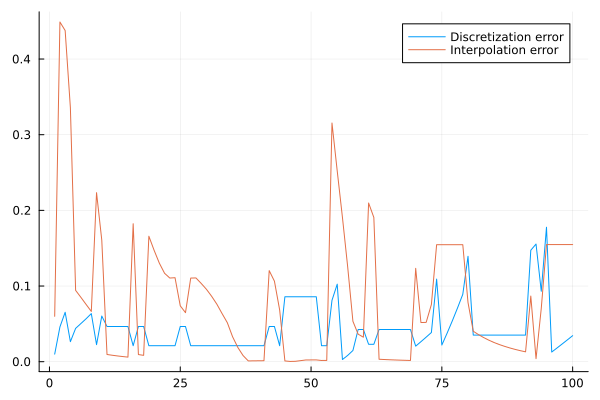

In [18]:
error_plot = plt.plot(errord, label="Discretization error")
error_plot = plt.plot!(errori, label="Interpolation error")

Surprisingly, our error in approximation is larger when using the linear interpolation method compared to the discretization method. This is likely because of some faulty code in the interpolation, but we will proceed as if discretization is superior.

**Problem 2C**

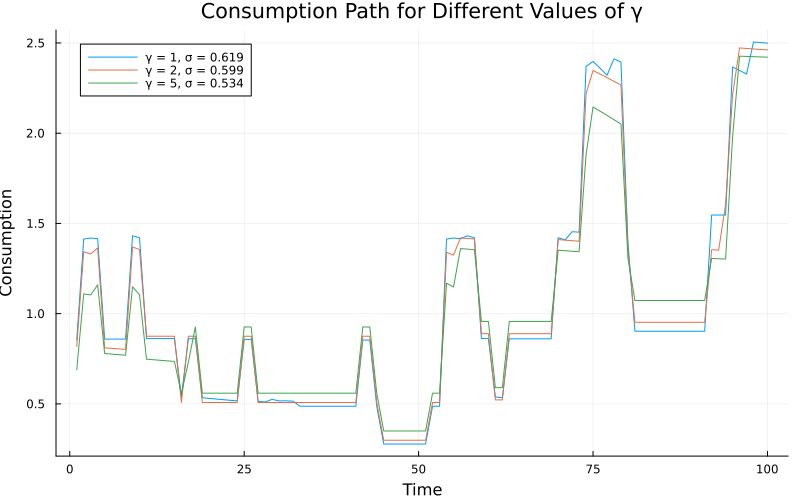

In [20]:
plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot

# Define gamma values
gamma_values = [1, 2, 5]

method = false

# Loop over gamma values
y_path = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
for γn in gamma_values
    A_dpolicy, Ay1_dpolicy = pfi_discretization(
        states,
        P,
        M,
        a_M,
        ϕ,
        ν,
        R,
        β,
        γn;
        max_iterations=1000,
        print_output=false
    )
    a_path = Array{Union{Float64, Missing}}(undef, periods)
    a_path[1] = Ay1_dpolicy[findfirst(asset -> asset == 0.0, A_dpolicy), findfirst(state -> state == y_path[1], states)]
    for t = 2:periods
        j = findfirst(state -> state == y_path[t], states)
        i = findfirst(asset -> asset == a_path[t-1], A_dpolicy)
        a_path[t] = Ay1_dpolicy[i, j]
    end
    c_path = Array{Union{Float64, Missing}}(undef, periods)
    c_path[1] = y_path[1] - a_path[1]
    for t = 2:periods
        c_path[t] = y_path[t] + R*a_path[t-1] - a_path[t]
    end

    # Calculate standard deviation of the consumption path
    std_dev = round(stats.std(c_path), digits=3)
    
    # Concatenate gamma and standard deviation to label
    label = "γ = $γn, σ = $std_dev"

    # Plot consumption path
    if γn == gamma_values[1]
        plt.plot!(plot_main, c_path, label = label)
    else
        plt.plot!(c_path, label = label)
    end
end

# Add labels and legend
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for Different Values of γ")


**Problem 2C**

As one would expect, standard deviation of consumption is decreasing as the coefficient of relative risk aversion is increasing. This makes sense as we expect that the more risk averse the agent is, the more they would want to smooth consumption to avoid unexpected shocks to endowment.


**Problem 2D**

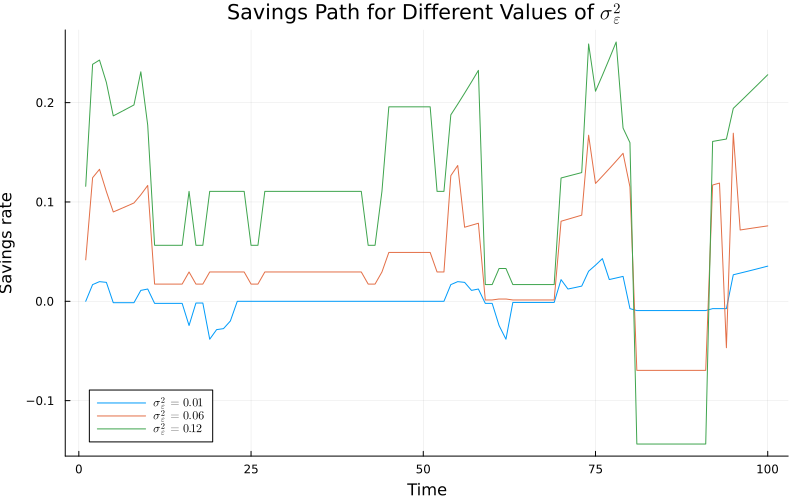

In [25]:
# Initialize main plot
plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot

# Define sigma values
innovation_variance = [0.01, 0.06, 0.12]

# Loop over sigma values
for variance in innovation_variance
    vₑ = variance
    σₑ = sqrt(vₑ)
    μₑ = 0
    ρ = 0.90
    w̄ = -vₑ / (2*(1 + ρ))
    v = σₑ / (1 - ρ^2)
    σ = sqrt(v)
    μ = w̄ / (1 - ρ)

    markov = rouwenhorst(w̄, vₑ, 5, ρ)

    states = exp.(markov.states)
    P = markov.theta

    y_path = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
    A_dpolicy, Ay1_dpolicy = pfi_discretization(
        states,
        P,
        M,
        a_M,
        ϕ,
        ν,
        R,
        β,
        γ;
        max_iterations=1000,
        print_output=false
    )
    a_path = Array{Union{Float64, Missing}}(undef, periods)
    a_path[1] = Ay1_dpolicy[findfirst(asset -> asset == 0.0, A_dpolicy), findfirst(state -> state == y_path[1], states)]
    for t = 2:periods
        j = findfirst(state -> state == y_path[t], states)
        i = findfirst(asset -> asset == a_path[t-1], A_dpolicy)
        a_path[t] = Ay1_dpolicy[i, j]
    end
    c_path = Array{Union{Float64, Missing}}(undef, periods)
    c_path[1] = y_path[1] - a_path[1]
    for t = 2:periods
        c_path[t] = y_path[t] + R*a_path[t-1] - a_path[t]
    end

    # Calculate savings rate
    for t = 2:periods
        a_path[t] = a_path[t-1]
    end
    a_path[1] = 0.0
    savings_path = 1 .- c_path./(y_path + R*a_path)
    
    # label string
    rounded_σ= round(σ, digits= 3)
    label_str = "\$\\sigma_{\\epsilon}^{2} = $variance\$"

    # Plot consumption path
    if variance == innovation_variance[1]
        plt.plot!(plot_main, savings_path, label = label_str)
    else
        plt.plot!(savings_path, label = label_str)
    end
end

# Add labels and legend
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Savings rate")
plt.title!(plot_main, "Savings Path for Different Values of \$\\sigma_{\\epsilon}^{2}\$")

We see that with larger innovations in the variance of income, the savings rate is larger. Again, this makes sense. If income is more uncertain, individuals would want to save more to insure against the income risk. The precautionary motive for savings is increasing the variance of income



**Problem 2E**

In [41]:
# Consumption-savings parameters
γ = 2
β = 0.95
r = 0.02
R = 1 + r

# Income process parameters
vₑ = 0.06
σₑ = sqrt(vₑ)
μₑ = 0
ρ = 0.90
w̄ = -vₑ / (2*(1 + ρ))
v = σₑ / (1 - ρ^2)
σ = sqrt(v)
μ = w̄ / (1 - ρ)

# Grid parameters
M = 100
ν = 3
a_M = 20

# Markov chain parameters
N = 5

markov = rouwenhorst(w̄, vₑ, 5, ρ)

states = exp.(markov.states)
P = markov.theta
;

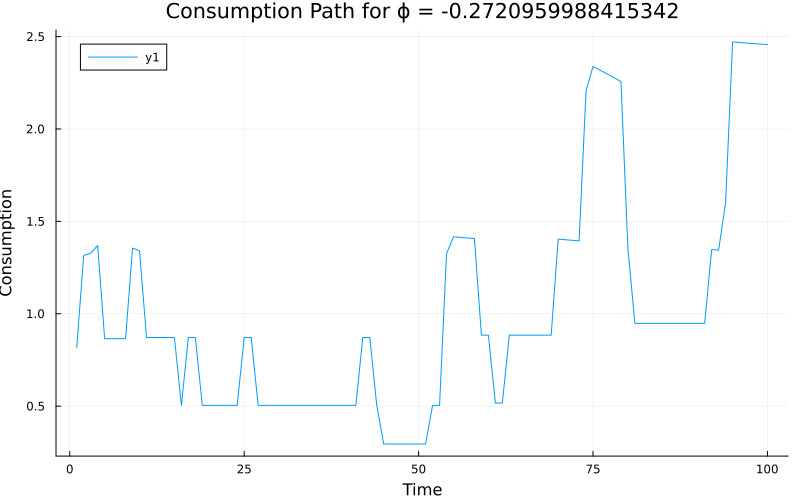

In [42]:
ϕ = -states[1] / R

A_dpolicy, Ay1_dpolicy = pfi_discretization(
    states,
    P,
    M,
    a_M,
    ϕ,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    print_output=false
)

periods = 100
Y = exp.(simulate!(markov, periods, 1000, 0; random_state=28))
Ad = Array{Union{Float64, Missing}}(undef, periods)
for i = 1:M-1
    if A_dpolicy[i] < 0.0 && A_dpolicy[i+1] > 0.0
        Ad[1] = A_dpolicy[i+1]
        break
    end
end
Ad1 = Array{Union{Float64, Missing}}(undef, periods)
Ad1[1] = Ay1_dpolicy[findfirst(asset -> asset == Ad[1], A_dpolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ad[t] = Ad1[t - 1]
    j = findfirst(state -> state == Y[t], states)
    i = findfirst(asset -> asset == Ad[t], A_dpolicy)
    Ad1[t] = Ay1_dpolicy[i, j]
end

Cd = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Cd[t] = Y[t] + R*Ad[t] - Ad1[t]
end

plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot
plt.plot!(plot_main, Cd)
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for ϕ = $ϕ")

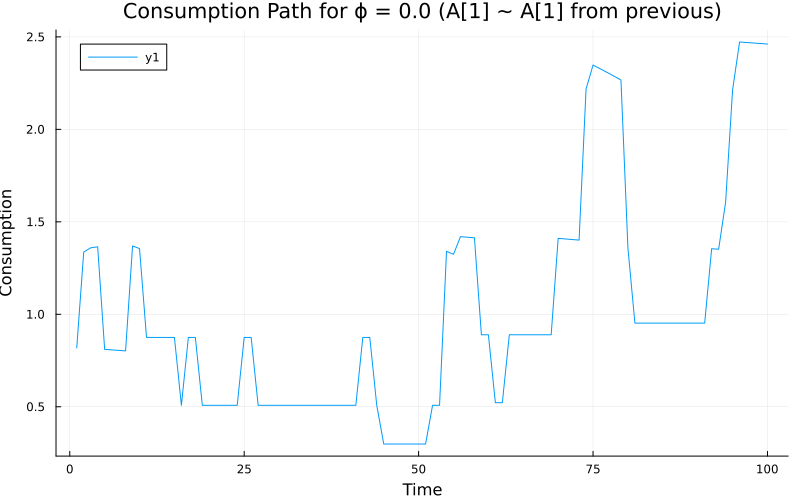

In [43]:
ϕ = 0.0

A_dpolicy, Ay1_dpolicy = pfi_discretization(
    states,
    P,
    M,
    a_M,
    0.0,
    ν,
    R,
    β,
    γ;
    max_iterations=1000,
    print_output=false
)
for i = 1:M-1
    if A_dpolicy[i] < Ad[1] && A_dpolicy[i+1] > Ad[1]
        Ad[1] = A_dpolicy[i+1]
        break
    end
end
Ad1 = Array{Union{Float64, Missing}}(undef, periods)
Ad1[1] = Ay1_dpolicy[findfirst(asset -> asset == Ad[1], A_dpolicy), findfirst(state -> state == Y[1], states)]
for t = 2:periods
    Ad[t] = Ad1[t - 1]
    j = findfirst(state -> state == Y[t], states)
    i = findfirst(asset -> asset == Ad[t], A_dpolicy)
    Ad1[t] = Ay1_dpolicy[i, j]
end

Cd = Array{Union{Float64, Missing}}(undef, periods)
for t = 1:periods
    Cd[t] = Y[t] + R*Ad[t] - Ad1[t]
end

plot_main = plt.plot(size=(800, 500))  # Adjust the size of the plot
plt.plot!(plot_main, Cd)
plt.xlabel!(plot_main, "Time")
plt.ylabel!(plot_main, "Consumption")
plt.title!(plot_main, "Consumption Path for ϕ = $ϕ (A[1] ~ A[1] from previous)")

We should see that by relaxing the "no-borrowing" constraint and using the natural debt limit instead increases the average consumption. This makes sense as households are now able to borrow to smooth consumption. The plot does not properly reflect this, likely due to some issue with the code.

**Problem 2F**

